In [165]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [166]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
 
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)
 
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

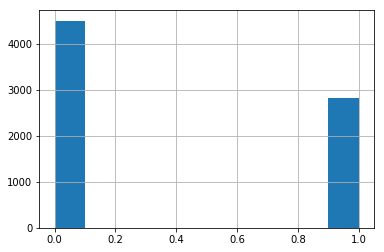

In [167]:
y_train.hist()

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [161]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04350791052918712
Percent Type II errors: 0.16448445171849427

Test set accuracy:
Percent Type I errors: 0.07239263803680981
Percent Type II errors: 0.17791411042944785


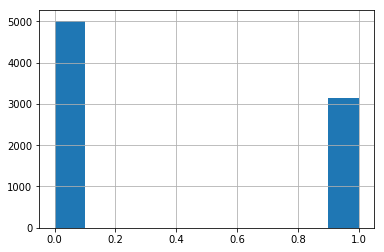

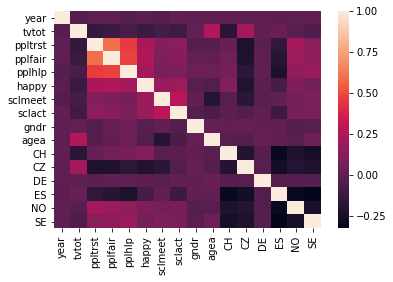

In [162]:
import seaborn as sns
sns.heatmap(X.corr())

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

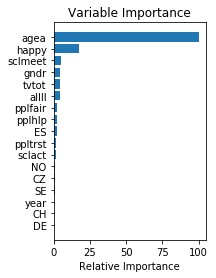

Index(['DE', 'CH', 'year', 'SE', 'CZ', 'NO', 'sclact', 'ppltrst', 'ES',
       'pplhlp', 'pplfair', 'allll', 'tvtot', 'gndr', 'sclmeet', 'happy',
       'agea'],
      dtype='object')


In [152]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
print(X.columns[sorted_idx] )

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [113]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

0 new random picked points


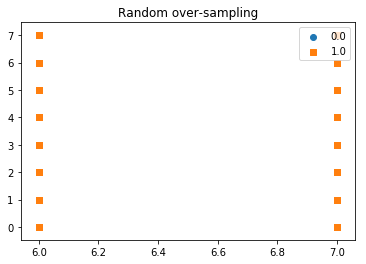

In [168]:
import imblearn
from matplotlib import pyplot as plt

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train, y_train = ros.fit_sample(X_train, y_train)

print(X_train.shape[0] - X_train.shape[0], 'new random picked points')

 
plot_2d_space(X_train, y_train , 'Random over-sampling')


(array([4508.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4508.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

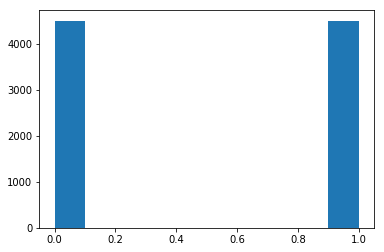

In [170]:
plt.hist(y_train)

In [172]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 15000,
          'max_depth': 1,
          'loss': 'exponential', 'random_state': 20, 'max_features': 'sqrt', 'max_leaf_nodes' : 30,
           'verbose' : 1 }

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']


print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


      Iter       Train Loss   Remaining Time 
         1           0.9968            0.00s
         2           0.9827           30.21s
         3           0.9802           40.14s
         4           0.9799           30.10s
         5           0.9733           35.99s
         6           0.9723           40.10s
         7           0.9664           34.37s
         8           0.9526           37.57s
         9           0.9517           33.39s
        10           0.9480           36.05s
        20           0.9064           30.00s
        30           0.8747           29.97s
        40           0.8463           28.44s
        50           0.8351           27.52s
        60           0.8287           26.90s
        70           0.8232           26.46s
        80           0.8178           26.12s
        90           0.8143           25.85s
       100           0.8106           25.64s
       200           0.7948           23.98s
       300           0.7827           23.81s
       40

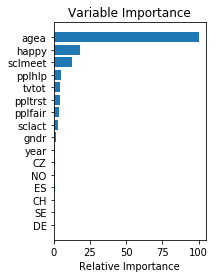

Index(['DE', 'SE', 'CH', 'ES', 'NO', 'CZ', 'year', 'gndr', 'sclact', 'pplfair',
       'ppltrst', 'tvtot', 'pplhlp', 'sclmeet', 'happy', 'agea'],
      dtype='object')


In [147]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
print(X.columns[sorted_idx])

In [118]:
# GridSearchCV for best parameters
from sklearn.model_selection import GridSearchCV
param_grid = dict(n_estimators=([1500]),max_depth=range(1,4,1),loss=['deviance'],subsample=np.arange(.1,1,.1))
grid = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=2,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_...      subsample=0.3, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1500], 'max_depth': range(1, 4), 'loss': ['deviance'], 'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [119]:
print(grid.best_params_)
print(grid.best_score_ )

{'loss': 'deviance', 'max_depth': 1, 'n_estimators': 1500, 'subsample': 0.2}
0.6880796508456083
